# Section 1.0 - Preprocessing + EDA

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import keras
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras.utils import plot_model
from keras.callbacks import TensorBoard
from google.colab import files

%matplotlib inline

pd.set_option('display.max_columns', 100)

Using TensorFlow backend.


## Section 1.1 - Reading test + train datasets

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
traindf = pd.read_csv('train.csv', dtype={'Upc': object,'TripType':object})
traindf.head()

TripType  VisitNumber Weekday          Upc  ScanCount  \
0      999            5  Friday  68113152929         -1   
1       30            7  Friday  60538815980          1   
2       30            7  Friday   7410811099          1   
3       26            8  Friday   2238403510          2   
4       26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber  
0     FINANCIAL SERVICES          1000.0  
1                  SHOES          8931.0  
2          PERSONAL CARE          4504.0  
3  PAINT AND ACCESSORIES          3565.0  
4  PAINT AND ACCESSORIES          1017.0

In [0]:
testdf = pd.read_csv('test.csv', dtype={'Upc': object,'TripType':object})
testdf.head()

VisitNumber Weekday          Upc  ScanCount DepartmentDescription  \
0            1  Friday  72503389714          1                 SHOES   
1            1  Friday   1707710732          1                 DAIRY   
2            1  Friday  89470001026          1                 DAIRY   
3            1  Friday  88491211470          1     GROCERY DRY GOODS   
4            2  Friday   2840015224          1           DSD GROCERY   

   FinelineNumber  
0          3002.0  
1          1526.0  
2          1431.0  
3          3555.0  
4          4408.0

In [0]:
traindf.shape

(647054, 7)

In [0]:
testdf.shape

(653646, 6)

## Section 1.2 - Data Imputation & Formatting

### From the Kaggle Page

Data fields
TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.

VisitNumber - an id corresponding to a single trip by a single customer
Weekday - the weekday of the trip

Upc - the UPC number of the product purchased

ScanCount - the number of the given item that was purchased. A negative value indicates a product return.

DepartmentDescription - a high-level description of the item's department

FinelineNumber - a more refined category for each of the products, created by Walmart

In [0]:
traindf.dtypes

TripType                  object
VisitNumber                int64
Weekday                   object
Upc                       object
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

In [0]:
## Reformatting of column types will be necessary; our label, TripType identifies a cluster that's been created
## by an unsupervised model (Created by the Walmart DS team). **Note; Upc + TripType is converted to an object in the initial csv read

In [0]:
traindf.tail(10)

TripType  VisitNumber Weekday          Upc  ScanCount  \
647044       39       191346  Sunday   5100019880          1   
647045       39       191346  Sunday   7874203977          1   
647046       39       191346  Sunday   3120020235          1   
647047       39       191346  Sunday   3120033013          1   
647048       39       191346  Sunday   3700091229          1   
647049       39       191346  Sunday  32390001778          1   
647050       39       191346  Sunday   7874205336          1   
647051       39       191346  Sunday         4072          1   
647052        8       191347  Sunday   4190007664          1   
647053        8       191347  Sunday   3800059655          1   

           DepartmentDescription  FinelineNumber  
647044         GROCERY DRY GOODS          3107.0  
647045                     DAIRY          7955.0  
647046               DSD GROCERY          4639.0  
647047               DSD GROCERY          4639.0  
647048  HOUSEHOLD CHEMICALS/SUPP          8947.0  
647049              PHARMACY OTC          1118.0  
647050              FROZEN FOODS          1752.0  
647051                   PRODUCE          4170.0  
647052                     DAIRY          1512.0  
647053         GROCERY DRY GOODS          3600.0

In [0]:
## Check missing values
traindf.isnull().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [0]:
testdf.isnull().sum()

VisitNumber                 0
Weekday                     0
Upc                      3986
ScanCount                   0
DepartmentDescription    1328
FinelineNumber           3986
dtype: int64

In [0]:
## Some missing values present; represented as a percentage of the total observations below
(traindf.isnull().sum()/traindf.shape[0])*100

## Data only represents approximately .63% of the total; due to this not really reducing from our total observations
## we can opt to remove these at this time. This may get revisited after the model evaluation.

TripType                 0.000000
VisitNumber              0.000000
Weekday                  0.000000
Upc                      0.638123
ScanCount                0.000000
DepartmentDescription    0.210338
FinelineNumber           0.638123
dtype: float64

In [0]:
traindf = traindf.dropna(how='any')

In [0]:
print(traindf.shape)
print(traindf.isnull().sum())

(642925, 7)
TripType                 0
VisitNumber              0
Weekday                  0
Upc                      0
ScanCount                0
DepartmentDescription    0
FinelineNumber           0
dtype: int64


In [0]:
#create visitnumber df for later reference
visitnumber = testdf.groupby(['VisitNumber'], sort = False).sum().reset_index()

Upon manual inspection of data, it appears as though there's an issue with the Upc codes. These consist of various lengths when they should be between 12 digits if a UPC-A code is assumed. UPC structure is identified by 'GS1' specifications which is commonly found in North America, however there must be consideration of foreign products given the scale of a retailer such as Walmart.

### In the next section a length count of each UPC code will be performed to get an understanding of whether the UPC-A format is followed collectively

In [0]:
UPClength = []
coderange = range(len(traindf['Upc']))

for i in coderange:
    Stringlength = len(traindf['Upc'].iloc[i])
    UPClength.append(Stringlength)

In [0]:
print(f' Average UPC length:', np.mean(UPClength))
print(f' Median UPC length:', np.median(UPClength))

 Average UPC length: 10.0030672317922
 Median UPC length: 10.0


In [0]:
traindf.shape

(642925, 7)

## Section 1.3 - Exploration

In [0]:
traindf.describe()

VisitNumber      ScanCount  FinelineNumber
count  642925.000000  642925.000000   642925.000000
mean    96199.870353       1.110203     3726.884567
std     55552.836758       0.701240     2780.966158
min         5.000000     -12.000000        0.000000
25%     49300.000000       1.000000     1404.000000
50%     97116.000000       1.000000     3352.000000
75%    144353.000000       1.000000     5501.000000
max    191347.000000      71.000000     9998.000000

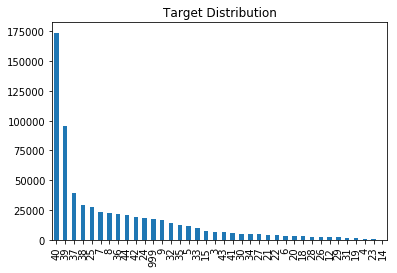

In [0]:
(traindf['TripType'].value_counts().plot(kind='bar', title='Target Distribution', figsize=(6,4)))

In [0]:
traindf.head(5)

TripType  VisitNumber Weekday          Upc  ScanCount  \
0      999            5  Friday  68113152929         -1   
1       30            7  Friday  60538815980          1   
2       30            7  Friday   7410811099          1   
3       26            8  Friday   2238403510          2   
4       26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber  
0     FINANCIAL SERVICES          1000.0  
1                  SHOES          8931.0  
2          PERSONAL CARE          4504.0  
3  PAINT AND ACCESSORIES          3565.0  
4  PAINT AND ACCESSORIES          1017.0

In [0]:
print(traindf.groupby('DepartmentDescription').size())
print(len(traindf.groupby('DepartmentDescription').size()),'total categories')
print(len(traindf.groupby('FinelineNumber').size()),'total subcategories')

DepartmentDescription
1-HR PHOTO                      394
ACCESSORIES                    1318
AUTOMOTIVE                     5414
BAKERY                         7168
BATH AND SHOWER                4582
BEAUTY                        14865
BEDDING                        2307
BOOKS AND MAGAZINES             992
BOYS WEAR                      3892
BRAS & SHAPEWEAR               2036
CAMERAS AND SUPPLIES            221
CANDY, TOBACCO, COOKIES        9808
CELEBRATION                    8698
COMM BREAD                    15244
CONCEPT STORES                   35
COOK AND DINE                  7600
DAIRY                         43820
DSD GROCERY                   68332
ELECTRONICS                    3190
FABRICS AND CRAFTS             5051
FINANCIAL SERVICES            10723
FROZEN FOODS                  21101
FURNITURE                       477
GIRLS WEAR, 4-6X  AND 7-14     4516
GROCERY DRY GOODS             70402
HARDWARE                       4913
HEALTH AND BEAUTY AIDS            2
HOME D

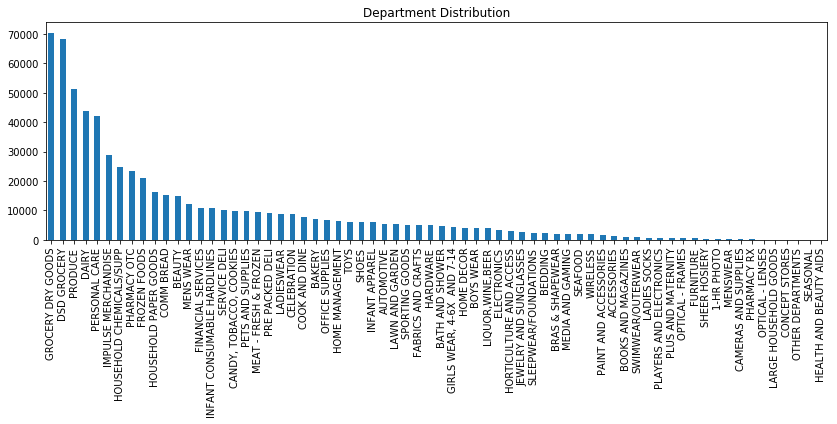

In [0]:
(traindf['DepartmentDescription'].value_counts().plot(kind='bar', title='Department Distribution', figsize=(14,4)))

## Section 1.4 - Feature Engineering

Merging every transaction onto the same line for training

There are three sections to this code:
- 1.4.1 - New columns for each department (and counts)
- 1.4.2 - New columns for week day (and counts)
- 1.4.3 - New columns for transaction types (and counts)
- 1.4.4 - Groupby for the visit numbers; Upc + FinelineNumbers to be discarded
- 1.4.5 - Condensing each transaction by trip number

### Section - 1.4.1

New columns for each department

In [0]:
departmentsplit = pd.get_dummies(traindf['DepartmentDescription'],drop_first=True)
departmentsplit_test = pd.get_dummies(testdf['DepartmentDescription'],drop_first=True)

In [0]:
traindf.head(3)

TripType  VisitNumber Weekday          Upc  ScanCount DepartmentDescription  \
0      999            5  Friday  68113152929         -1    FINANCIAL SERVICES   
1       30            7  Friday  60538815980          1                 SHOES   
2       30            7  Friday   7410811099          1         PERSONAL CARE   

   FinelineNumber  
0          1000.0  
1          8931.0  
2          4504.0

In [0]:
traindf.shape

(642925, 7)

In [0]:
traindf = pd.concat([traindf, departmentsplit], axis=1).reindex(traindf.index)
testdf = pd.concat([testdf, departmentsplit], axis=1).reindex(testdf.index)

In [0]:
traindf.head()

TripType  VisitNumber Weekday          Upc  ScanCount  \
0      999            5  Friday  68113152929         -1   
1       30            7  Friday  60538815980          1   
2       30            7  Friday   7410811099          1   
3       26            8  Friday   2238403510          2   
4       26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber  ACCESSORIES  AUTOMOTIVE  BAKERY  \
0     FINANCIAL SERVICES          1000.0            0           0       0   
1                  SHOES          8931.0            0           0       0   
2          PERSONAL CARE          4504.0            0           0       0   
3  PAINT AND ACCESSORIES          3565.0            0           0       0   
4  PAINT AND ACCESSORIES          1017.0            0           0       0   

   ...  SEAFOOD  SEASONAL  SERVICE DELI  SHEER HOSIERY  SHOES  \
0  ...        0         0             0              0      0   
1  ...        0         0             0              0      1   
2  ...        0         0             0              0      0   
3  ...        0         0             0              0      0   
4  ...        0         0             0              0      0   

   SLEEPWEAR/FOUNDATIONS  SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  
0                      0               0                   0     0         0  
1                      0               0                   0     0         0  
2                      0               0                   0     0         0  
3                      0               0                   0     0         0  
4                      0               0                   0     0         0  

[5 rows x 74 columns]

In [0]:
testdf.head()

VisitNumber Weekday          Upc  ScanCount DepartmentDescription  \
0            1  Friday  72503389714          1                 SHOES   
1            1  Friday   1707710732          1                 DAIRY   
2            1  Friday  89470001026          1                 DAIRY   
3            1  Friday  88491211470          1     GROCERY DRY GOODS   
4            2  Friday   2840015224          1           DSD GROCERY   

   FinelineNumber  ACCESSORIES  AUTOMOTIVE  BAKERY  BATH AND SHOWER  ...  \
0          3002.0          0.0         0.0     0.0              0.0  ...   
1          1526.0          0.0         0.0     0.0              0.0  ...   
2          1431.0          0.0         0.0     0.0              0.0  ...   
3          3555.0          0.0         0.0     0.0              0.0  ...   
4          4408.0          0.0         0.0     0.0              0.0  ...   

   SEAFOOD  SEASONAL  SERVICE DELI  SHEER HOSIERY  SHOES  \
0      0.0       0.0           0.0            0.0    0.0   
1      0.0       0.0           0.0            0.0    1.0   
2      0.0       0.0           0.0            0.0    0.0   
3      0.0       0.0           0.0            0.0    0.0   
4      0.0       0.0           0.0            0.0    0.0   

   SLEEPWEAR/FOUNDATIONS  SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  
0                    0.0             0.0                 0.0   0.0       0.0  
1                    0.0             0.0                 0.0   0.0       0.0  
2                    0.0             0.0                 0.0   0.0       0.0  
3                    0.0             0.0                 0.0   0.0       0.0  
4                    0.0             0.0                 0.0   0.0       0.0  

[5 rows x 73 columns]

### Section - 1.4.2

Day of week encoded

In [0]:
weekdaysplit = pd.get_dummies(traindf['Weekday'], drop_first=True)
weekdaysplit_test = pd.get_dummies(testdf['Weekday'], drop_first=True)

In [0]:
traindf = pd.concat([traindf, weekdaysplit], axis=1).reindex(traindf.index)
testdf = pd.concat([testdf, weekdaysplit], axis=1).reindex(testdf.index)

In [0]:
traindf.head()

TripType  VisitNumber Weekday          Upc  ScanCount  \
0      999            5  Friday  68113152929         -1   
1       30            7  Friday  60538815980          1   
2       30            7  Friday   7410811099          1   
3       26            8  Friday   2238403510          2   
4       26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber  ACCESSORIES  AUTOMOTIVE  BAKERY  \
0     FINANCIAL SERVICES          1000.0            0           0       0   
1                  SHOES          8931.0            0           0       0   
2          PERSONAL CARE          4504.0            0           0       0   
3  PAINT AND ACCESSORIES          3565.0            0           0       0   
4  PAINT AND ACCESSORIES          1017.0            0           0       0   

   ...  SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  Monday  Saturday  \
0  ...               0                   0     0         0       0         0   
1  ...               0                   0     0         0       0         0   
2  ...               0                   0     0         0       0         0   
3  ...               0                   0     0         0       0         0   
4  ...               0                   0     0         0       0         0   

   Sunday  Thursday  Tuesday  Wednesday  
0       0         0        0          0  
1       0         0        0          0  
2       0         0        0          0  
3       0         0        0          0  
4       0         0        0          0  

[5 rows x 80 columns]

In [0]:
testdf.head()

VisitNumber Weekday          Upc  ScanCount DepartmentDescription  \
0            1  Friday  72503389714          1                 SHOES   
1            1  Friday   1707710732          1                 DAIRY   
2            1  Friday  89470001026          1                 DAIRY   
3            1  Friday  88491211470          1     GROCERY DRY GOODS   
4            2  Friday   2840015224          1           DSD GROCERY   

   FinelineNumber  ACCESSORIES  AUTOMOTIVE  BAKERY  BATH AND SHOWER  ...  \
0          3002.0          0.0         0.0     0.0              0.0  ...   
1          1526.0          0.0         0.0     0.0              0.0  ...   
2          1431.0          0.0         0.0     0.0              0.0  ...   
3          3555.0          0.0         0.0     0.0              0.0  ...   
4          4408.0          0.0         0.0     0.0              0.0  ...   

   SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  Monday  Saturday  \
0             0.0                 0.0   0.0       0.0     0.0       0.0   
1             0.0                 0.0   0.0       0.0     0.0       0.0   
2             0.0                 0.0   0.0       0.0     0.0       0.0   
3             0.0                 0.0   0.0       0.0     0.0       0.0   
4             0.0                 0.0   0.0       0.0     0.0       0.0   

   Sunday  Thursday  Tuesday  Wednesday  
0     0.0       0.0      0.0        0.0  
1     0.0       0.0      0.0        0.0  
2     0.0       0.0      0.0        0.0  
3     0.0       0.0      0.0        0.0  
4     0.0       0.0      0.0        0.0  

[5 rows x 79 columns]

In [0]:
print('Total columns on training set:',traindf.shape[1])
print('Total columns on test set:',testdf.shape[1])

Total columns on training set: 80
Total columns on test set: 79


In [0]:
traindf.dtypes

TripType                       object
VisitNumber                     int64
Weekday                        object
Upc                            object
ScanCount                       int64
DepartmentDescription          object
FinelineNumber                float64
ACCESSORIES                     uint8
AUTOMOTIVE                      uint8
BAKERY                          uint8
BATH AND SHOWER                 uint8
BEAUTY                          uint8
BEDDING                         uint8
BOOKS AND MAGAZINES             uint8
BOYS WEAR                       uint8
BRAS & SHAPEWEAR                uint8
CAMERAS AND SUPPLIES            uint8
CANDY, TOBACCO, COOKIES         uint8
CELEBRATION                     uint8
COMM BREAD                      uint8
CONCEPT STORES                  uint8
COOK AND DINE                   uint8
DAIRY                           uint8
DSD GROCERY                     uint8
ELECTRONICS                     uint8
FABRICS AND CRAFTS              uint8
FINANCIAL SE

In [0]:
testdf.dtypes

VisitNumber                     int64
Weekday                        object
Upc                            object
ScanCount                       int64
DepartmentDescription          object
FinelineNumber                float64
ACCESSORIES                   float64
AUTOMOTIVE                    float64
BAKERY                        float64
BATH AND SHOWER               float64
BEAUTY                        float64
BEDDING                       float64
BOOKS AND MAGAZINES           float64
BOYS WEAR                     float64
BRAS & SHAPEWEAR              float64
CAMERAS AND SUPPLIES          float64
CANDY, TOBACCO, COOKIES       float64
CELEBRATION                   float64
COMM BREAD                    float64
CONCEPT STORES                float64
COOK AND DINE                 float64
DAIRY                         float64
DSD GROCERY                   float64
ELECTRONICS                   float64
FABRICS AND CRAFTS            float64
FINANCIAL SERVICES            float64
FROZEN FOODS

### Section - 1.4.3

Generating sub-categories

In [0]:
traindf['Return'] = traindf['ScanCount'].apply(lambda x: 'Returned' if x < 0 else 'Bought')

In [0]:
traindf['Count_of_Item'] = traindf['ScanCount'].apply(lambda x: 'Multiple' if x > 1 or x < -1 else 'Single')

In [0]:

condensed_categories = {'1-HR PHOTO':'Photo', 
 'ACCESSORIES':'Clothing,Shoes,and Accessories',
 'AUTOMOTIVE':'Auto', 
 'BAKERY':'Food',
 'BATH AND SHOWER':'Home,Furniture,and Appliances',
 'BEAUTY':'Pharmacy,Health,and Beauty',
 'BEDDING':'Home,Furniture,and Appliances', 
 'BOOKS AND MAGAZINES':'Movies,Music,and Books',
 'BOYS WEAR':'Clothing,Shoes,and Accessories',
 'BRAS & SHAPEWEAR':'Clothing,Shoes,and Accessories', 
 'CAMERAS AND SUPPLIES':'Electronics',
 'CANDY, TOBACCO, COOKIES':'Food', 
 'CELEBRATION':'Gifts and Crafts', 
 'COMM BREAD':'Food',
 'CONCEPT STORES':'Specialty Stores',
 'COOK AND DINE':'Home,Furniture,and Appliances',
 'DAIRY':'Food', 
 'DSD GROCERY':'Food',
 'ELECTRONICS':'Electronics',
 'FABRICS AND CRAFTS':'Home Improvement and Patio',
 'FINANCIAL SERVICES':'Financial Services',
 'FROZEN FOODS':'Food',
 'FURNITURE':'Home,Furniture,and Appliances',
 'GIRLS WEAR, 4-6X  AND 7-14':'Clothing,Shoes,and Accessories',
 'GROCERY DRY GOODS': 'Food',
 'HARDWARE':'Electronics',
 'HEALTH AND BEAUTY AIDS':'Pharmacy,Health,and Beauty',
 'HOME DECOR':'Home Improvement and Patio', 
 'HOME MANAGEMENT':'Home Improvement and Patio',
 'HORTICULTURE AND ACCESS': 'Home Improvement and Patio',
 'HOUSEHOLD CHEMICALS/SUPP': 'Home,Furniture,and Appliances', 
 'HOUSEHOLD PAPER GOODS':'Home Improvement and Patio',
 'IMPULSE MERCHANDISE':'Home,Furniture,and Appliances', 
 'INFANT APPAREL':'Clothing,Shoes,and Accessories',
 'INFANT CONSUMABLE HARDLINES':'Baby', 
 'JEWELRY AND SUNGLASSES': 'Clothing,Shoes,and Accessories',
 'LADIES SOCKS':'Clothing,Shoes,and Accessories', 
 'LADIESWEAR':'Clothing,Shoes,and Accessories',
 'LARGE HOUSEHOLD GOODS':'Clothing,Shoes,and Accessories',
 'LAWN AND GARDEN':'Clothing,Shoes,and Accessories', 
 'LIQUOR,WINE,BEER':'Food',
 'MEAT - FRESH & FROZEN':'Food',
 'MEDIA AND GAMING':'Toys and Games', 
 'MENS WEAR':'Clothing,Shoes,and Accessories',
 'MENSWEAR': 'Clothing,Shoes,and Accessories',
 'OFFICE SUPPLIES':'Office',
 'OPTICAL - FRAMES':'Pharmacy,Health,and Beauty', 
 'OPTICAL - LENSES':'Pharmacy,Health,and Beauty', 
 'OTHER DEPARTMENTS':'Other',
 'PAINT AND ACCESSORIES':'Home Improvement and Patio',
 'PERSONAL CARE': 'Pharmacy,Health,and Beauty', 
 'PETS AND SUPPLIES':'Pets',
 'PHARMACY OTC':'Pharmacy,Health,and Beauty', 
 'PHARMACY RX':'Pharmacy,Health,and Beauty', 
 'PLAYERS AND ELECTRONICS':'Electronics',
 'PLUS AND MATERNITY':'Clothing,Shoes,and Accessories',
 'PRE PACKED DELI':'Food',
 'PRODUCE':'Food',
 'SEAFOOD':'Food',
 'SEASONAL':'Seasonal', 
 'SERVICE DELI':'Food',
 'SHEER HOSIERY':'Clothing,Shoes,and Accessories',
 'SHOES':'Clothing,Shoes,and Accessories',
 'SLEEPWEAR/FOUNDATIONS':'Clothing,Shoes,and Accessories',
 'SPORTING GOODS':'Sports',
 'SWIMWEAR/OUTERWEAR':'Clothing,Shoes,and Accessories',
 'TOYS':'Toys and Games', 
 'WIRELESS':'Electronics',
 'nan':'Unknown'}


In [0]:
traindf['condensed_categories'] = traindf['DepartmentDescription'].map(condensed_categories)

In [0]:
categoriesdummied = pd.get_dummies(traindf,columns= ['condensed_categories','Return','Count_of_Item'])

In [0]:
categoriesdummied.head(5)

TripType  VisitNumber Weekday          Upc  ScanCount  \
0      999            5  Friday  68113152929         -1   
1       30            7  Friday  60538815980          1   
2       30            7  Friday   7410811099          1   
3       26            8  Friday   2238403510          2   
4       26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber  ACCESSORIES  AUTOMOTIVE  BAKERY  \
0     FINANCIAL SERVICES          1000.0            0           0       0   
1                  SHOES          8931.0            0           0       0   
2          PERSONAL CARE          4504.0            0           0       0   
3  PAINT AND ACCESSORIES          3565.0            0           0       0   
4  PAINT AND ACCESSORIES          1017.0            0           0       0   

   ...  condensed_categories_Pharmacy,Health,and Beauty  \
0  ...                                                0   
1  ...                                                0   
2  ...                                                1   
3  ...                                                0   
4  ...                                                0   

   condensed_categories_Photo  condensed_categories_Seasonal  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   condensed_categories_Specialty Stores  condensed_categories_Sports  \
0                                      0                            0   
1                                      0                            0   
2                                      0                            0   
3                                      0                            0   
4                                      0                            0   

   condensed_categories_Toys and Games  Return_Bought  Return_Returned  \
0                                    0              0                1   
1                                    0              1                0   
2                                    0              1                0   
3                                    0              1                0   
4                                    0              1                0   

   Count_of_Item_Multiple  Count_of_Item_Single  
0                       0                     1  
1                       0                     1  
2                       0                     1  
3                       1                     0  
4                       1                     0  

[5 rows x 103 columns]

In [0]:
categoriesdummied.shape

(642925, 103)

In [0]:
categoriesdummied = categoriesdummied.drop(['Upc','Weekday','DepartmentDescription','FinelineNumber'],axis=1)

In [0]:
testdf = testdf.drop(['Upc','Weekday','DepartmentDescription','FinelineNumber'],axis=1)

In [0]:
list(categoriesdummied.columns)

['TripType',
 'VisitNumber',
 'ScanCount',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'P

In [0]:
#testing dropping a bunch of categories
categoriesdummied = categoriesdummied.drop([ 'condensed_categories_Auto',
 'condensed_categories_Baby',
 'condensed_categories_Clothing,Shoes,and Accessories',
 'condensed_categories_Electronics',
 'condensed_categories_Financial Services',
 'condensed_categories_Food',
 'condensed_categories_Gifts and Crafts',
 'condensed_categories_Home Improvement and Patio',
 'condensed_categories_Home,Furniture,and Appliances',
 'condensed_categories_Movies,Music,and Books',
 'condensed_categories_Office',
 'condensed_categories_Other',
 'condensed_categories_Pets',
 'condensed_categories_Pharmacy,Health,and Beauty',
 'condensed_categories_Photo',
 'condensed_categories_Seasonal',
 'condensed_categories_Specialty Stores',
 'condensed_categories_Sports',
 'condensed_categories_Toys and Games',
 'Return_Bought',
 'Return_Returned',
 'Count_of_Item_Multiple',
 'Count_of_Item_Single'],axis=1)

In [0]:
categoriesdummied.head(5)

TripType  VisitNumber  ScanCount  ACCESSORIES  AUTOMOTIVE  BAKERY  \
0      999            5         -1            0           0       0   
1       30            7          1            0           0       0   
2       30            7          1            0           0       0   
3       26            8          2            0           0       0   
4       26            8          2            0           0       0   

   BATH AND SHOWER  BEAUTY  BEDDING  BOOKS AND MAGAZINES  ...  SPORTING GOODS  \
0                0       0        0                    0  ...               0   
1                0       0        0                    0  ...               0   
2                0       0        0                    0  ...               0   
3                0       0        0                    0  ...               0   
4                0       0        0                    0  ...               0   

   SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  Monday  Saturday  Sunday  Thursday  \
0                   0     0         0       0         0       0         0   
1                   0     0         0       0         0       0         0   
2                   0     0         0       0         0       0         0   
3                   0     0         0       0         0       0         0   
4                   0     0         0       0         0       0         0   

   Tuesday  Wednesday  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  

[5 rows x 76 columns]

In [0]:
traindf.head()

TripType  VisitNumber Weekday          Upc  ScanCount  \
0      999            5  Friday  68113152929         -1   
1       30            7  Friday  60538815980          1   
2       30            7  Friday   7410811099          1   
3       26            8  Friday   2238403510          2   
4       26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber  ACCESSORIES  AUTOMOTIVE  BAKERY  \
0     FINANCIAL SERVICES          1000.0            0           0       0   
1                  SHOES          8931.0            0           0       0   
2          PERSONAL CARE          4504.0            0           0       0   
3  PAINT AND ACCESSORIES          3565.0            0           0       0   
4  PAINT AND ACCESSORIES          1017.0            0           0       0   

   ...  WIRELESS  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  \
0  ...         0       0         0       0         0        0          0   
1  ...         0       0         0       0         0        0          0   
2  ...         0       0         0       0         0        0          0   
3  ...         0       0         0       0         0        0          0   
4  ...         0       0         0       0         0        0          0   

     Return  Count_of_Item            condensed_categories  
0  Returned         Single              Financial Services  
1    Bought         Single  Clothing,Shoes,and Accessories  
2    Bought         Single      Pharmacy,Health,and Beauty  
3    Bought       Multiple      Home Improvement and Patio  
4    Bought       Multiple      Home Improvement and Patio  

[5 rows x 83 columns]

Splitting out trip types from the primary dataframe to rejoin later as we progress through the grouping process

In [0]:
#commented out
#typevisit = categoriesdummied[['TripType','VisitNumber']]

In [0]:
#commented out
#typevisit.head(3)

In [0]:
#categoriesdummied = categoriesdummied.drop(columns=['TripType'])

### Section - 1.4.4

In [0]:
##Converting VisitNumber to string format
#categoriesdummied['VisitNumber'] = categoriesdummied['VisitNumber'].astype(str)

In [0]:
categoriesdummied = categoriesdummied.groupby(['TripType', 'VisitNumber'], as_index=False, sort=False).sum()

In [0]:
testdf = testdf.groupby(['VisitNumber'], as_index=False, sort=False).sum()

In [0]:
categoriesdummied = categoriesdummied.drop(['VisitNumber'], axis = 1)

In [0]:
testdf = testdf.drop(['VisitNumber'], axis = 1)

In [0]:
categoriesdummied.head()

TripType  ScanCount  ACCESSORIES  AUTOMOTIVE  BAKERY  BATH AND SHOWER  \
0      999         -1            0           0       0                0   
1       30          2            0           0       0                0   
2       26         27            0           0       0                0   
3        8          3            0           0       0                0   
4        8          3            0           0       0                0   

   BEAUTY  BEDDING  BOOKS AND MAGAZINES  BOYS WEAR  ...  SPORTING GOODS  \
0       0        0                    0          0  ...               0   
1       0        0                    0          0  ...               0   
2       0        0                    0          0  ...               0   
3       0        0                    0          0  ...               0   
4       0        0                    0          0  ...               0   

   SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  Monday  Saturday  Sunday  Thursday  \
0                   0     0         0       0         0       0         0   
1                   0     0         0       0         0       0         0   
2                   0     0         0       0         0       0         0   
3                   0     0         0       0         0       0         0   
4                   0     0         0       0         0       0         0   

   Tuesday  Wednesday  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          0  

[5 rows x 75 columns]

In [0]:
testdf.head()

ScanCount  ACCESSORIES  AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  \
0          4          0.0         0.0     0.0              0.0     0.0   
1          4          0.0         0.0     0.0              0.0     0.0   
2          0          0.0         0.0     0.0              0.0     0.0   
3          1          0.0         0.0     0.0              0.0     0.0   
4          0          0.0         0.0     0.0              0.0     0.0   

   BEDDING  BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  ...  \
0      0.0                  0.0        0.0               0.0  ...   
1      0.0                  0.0        0.0               0.0  ...   
2      0.0                  0.0        0.0               0.0  ...   
3      0.0                  0.0        0.0               0.0  ...   
4      0.0                  0.0        0.0               0.0  ...   

   SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  Monday  Saturday  \
0             0.0                 0.0   0.0       0.0     0.0       0.0   
1             0.0                 0.0   0.0       0.0     0.0       0.0   
2             0.0                 0.0   0.0       0.0     0.0       0.0   
3             0.0                 0.0   0.0       0.0     0.0       0.0   
4             0.0                 0.0   0.0       0.0     0.0       0.0   

   Sunday  Thursday  Tuesday  Wednesday  
0     0.0       0.0      0.0        0.0  
1     0.0       0.0      0.0        0.0  
2     0.0       0.0      0.0        0.0  
3     0.0       0.0      0.0        0.0  
4     0.0       0.0      0.0        0.0  

[5 rows x 74 columns]

In [0]:
  categoriesdummied.shape

(94247, 75)

In [0]:
X = categoriesdummied.drop(['TripType'], axis = 1)
y = categoriesdummied['TripType']

## Section 2.0 - Model Fitting & Evaluation

### Section 2.1 - Model Split & Fitting

In [0]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [0]:
xTrain.shape

(75397, 74)

In [0]:
#one-hot encoding label data
yTrain = pd.get_dummies(yTrain, drop_first=False)
yTrain.shape

(75397, 38)

In [0]:
xTest.shape

(18850, 74)

In [0]:
#one-hot encoding label data
yTest = pd.get_dummies(yTest, drop_first=False)
yTest.shape

(18850, 38)

In [0]:
xTrain.head()

ScanCount  ACCESSORIES  AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  \
45944          5            0           0       0                0       0   
4338           1            0           0       0                0       0   
62043          3            0           0       0                0       0   
29809          9            0           0       0                0       0   
73670         21            0           0       4                0       0   

       BEDDING  BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  ...  \
45944        0                    0          0                 0  ...   
4338         0                    0          0                 0  ...   
62043        0                    0          0                 0  ...   
29809        0                    0          0                 0  ...   
73670        0                    0          0                 0  ...   

       SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  Monday  Saturday  \
45944               0                   0     0         0       0         4   
4338                0                   0     0         0       0         1   
62043               0                   0     0         0       0         0   
29809               0                   0     0         0       0         0   
73670               0                   0     0         0       0         0   

       Sunday  Thursday  Tuesday  Wednesday  
45944       0         0        0          0  
4338        0         0        0          0  
62043       0         3        0          0  
29809       7         0        0          0  
73670      21         0        0          0  

[5 rows x 74 columns]

In [0]:
xTest.head()

ScanCount  ACCESSORIES  AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  \
43598          3            0           0       0                0       0   
3229          -1            0           0       0                1       0   
9434           7            0           0       0                0       0   
632            7            0           0       0                0       0   
87702          0            0           0       0                0       0   

       BEDDING  BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  ...  \
43598        1                    0          0                 0  ...   
3229         0                    0          0                 0  ...   
9434         0                    0          0                 0  ...   
632          0                    0          0                 0  ...   
87702        0                    0          0                 0  ...   

       SPORTING GOODS  SWIMWEAR/OUTERWEAR  TOYS  WIRELESS  Monday  Saturday  \
43598               0                   0     0         0       0         0   
3229                0                   0     0         0       0         1   
9434                1                   0     0         0       0         0   
632                 0                   0     0         0       0         0   
87702               4                   0     0         0       0         6   

       Sunday  Thursday  Tuesday  Wednesday  
43598       0         0        0          0  
3229        0         0        0          0  
9434        6         0        0          0  
632         0         0        0          0  
87702       0         0        0          0  

[5 rows x 74 columns]

In [0]:
#normalizing data
mean = xTrain.mean(axis=0)
xTrain -= mean

std = xTrain.std(axis=0)
xTrain /= std

xTest -= mean
xTest/= std

In [0]:
#normalizing test data
testdf -= mean
testdf /= std

### Section 2.2 - Neural Net

In [0]:
testdf.head()

ScanCount  ACCESSORIES  AUTOMOTIVE    BAKERY  BATH AND SHOWER    BEAUTY  \
0  -0.347270    -0.077336   -0.150689 -0.221396        -0.104954 -0.230774   
1  -0.347270    -0.077336   -0.150689 -0.221396        -0.104954 -0.230774   
2  -0.734505    -0.077336   -0.150689 -0.221396        -0.104954 -0.230774   
3  -0.637696    -0.077336   -0.150689 -0.221396        -0.104954 -0.230774   
4  -0.734505    -0.077336   -0.150689 -0.221396        -0.104954 -0.230774   

   BEDDING  BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  \
0 -0.09949              -0.0744  -0.096768         -0.095215   
1 -0.09949              -0.0744  -0.096768         -0.095215   
2 -0.09949              -0.0744  -0.096768         -0.095215   
3 -0.09949              -0.0744  -0.096768         -0.095215   
4 -0.09949              -0.0744  -0.096768         -0.095215   

   CAMERAS AND SUPPLIES  CANDY, TOBACCO, COOKIES  CELEBRATION  COMM BREAD  \
0             -0.043078                -0.202124    -0.152231   -0.291907   
1             -0.043078                -0.202124    -0.152231   -0.291907   
2             -0.043078                -0.202124    -0.152231   -0.291907   
3             -0.043078                -0.202124    -0.152231   -0.291907   
4             -0.043078                -0.202124    -0.152231   -0.291907   

   CONCEPT STORES  COOK AND DINE     DAIRY  DSD GROCERY  ELECTRONICS  \
0       -0.019951      -0.159905 -0.363028    -0.463694    -0.155459   
1       -0.019951      -0.159905 -0.363028    -0.463694    -0.155459   
2       -0.019951      -0.159905 -0.363028    -0.463694    -0.155459   
3       -0.019951      -0.159905 -0.363028     0.174889    -0.155459   
4       -0.019951      -0.159905 -0.363028    -0.463694    -0.155459   

   FABRICS AND CRAFTS  FINANCIAL SERVICES  FROZEN FOODS  FURNITURE  \
0           -0.108556            2.216912     -0.254803  -0.059485   
1           -0.108556           -0.282841     -0.254803  -0.059485   
2           -0.108556           -0.282841     -0.254803  -0.059485   
3           -0.108556           -0.282841     -0.254803  -0.059485   
4           -0.108556           -0.282841     -0.254803  -0.059485   

   GIRLS WEAR, 4-6X  AND 7-14  GROCERY DRY GOODS  HARDWARE  \
0                   -0.099084          -0.348643 -0.164446   
1                   -0.099084          -0.348643 -0.164446   
2                   -0.099084          -0.348643 -0.164446   
3                   -0.099084          -0.348643 -0.164446   
4                   -0.099084          -0.348643 -0.164446   

   HEALTH AND BEAUTY AIDS  HOME DECOR  HOME MANAGEMENT  \
0                -0.00515   -0.134917        -0.180591   
1                -0.00515   -0.134917        -0.180591   
2                -0.00515   -0.134917        -0.180591   
3                -0.00515   -0.134917        -0.180591   
4                -0.00515   -0.134917        -0.180591   

   HORTICULTURE AND ACCESS  HOUSEHOLD CHEMICALS/SUPP  HOUSEHOLD PAPER GOODS  \
0                -0.089353                 -0.282286              -0.279159   
1                -0.089353                 -0.282286              -0.279159   
2                -0.089353                 -0.282286              -0.279159   
3                -0.089353                 -0.282286              -0.279159   
4                -0.089353                 -0.282286              -0.279159   

   IMPULSE MERCHANDISE  INFANT APPAREL  INFANT CONSUMABLE HARDLINES  \
0            -0.416522       -0.103421                    -0.158464   
1            -0.416522       -0.103421                    -0.158464   
2            -0.416522       -0.103421                    -0.158464   
3            -0.416522       -0.103421                    -0.158464   
4            -0.416522       -0.103421                    -0.158464   

   JEWELRY AND SUNGLASSES  LADIES SOCKS  LADIESWEAR  LARGE HOUSEHOLD GOODS  \
0                -0.11403     -0.069627   -0.161573              -0.029374   
1                -0.11403     -0.069627   -0.161573 

In [0]:
xTest.head()

ScanCount  ACCESSORIES  AUTOMOTIVE    BAKERY  BATH AND SHOWER  \
43598  -0.444079    -0.077336   -0.150689 -0.221396        -0.104954   
3229   -0.831314    -0.077336   -0.150689 -0.221396         2.080406   
9434   -0.056843    -0.077336   -0.150689 -0.221396        -0.104954   
632    -0.056843    -0.077336   -0.150689 -0.221396        -0.104954   
87702  -0.734505    -0.077336   -0.150689 -0.221396        -0.104954   

         BEAUTY   BEDDING  BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  \
43598 -0.230774  4.013051              -0.0744  -0.096768         -0.095215   
3229  -0.230774 -0.099490              -0.0744  -0.096768         -0.095215   
9434  -0.230774 -0.099490              -0.0744  -0.096768         -0.095215   
632   -0.230774 -0.099490              -0.0744  -0.096768         -0.095215   
87702 -0.230774 -0.099490              -0.0744  -0.096768         -0.095215   

       CAMERAS AND SUPPLIES  CANDY, TOBACCO, COOKIES  CELEBRATION  COMM BREAD  \
43598             -0.043078                -0.202124    -0.152231   -0.291907   
3229              -0.043078                -0.202124    -0.152231   -0.291907   
9434              -0.043078                -0.202124    -0.152231   -0.291907   
632               -0.043078                -0.202124    -0.152231   -0.291907   
87702             -0.043078                -0.202124    -0.152231   -0.291907   

       CONCEPT STORES  COOK AND DINE     DAIRY  DSD GROCERY  ELECTRONICS  \
43598       -0.019951      -0.159905 -0.363028    -0.463694    -0.155459   
3229        -0.019951      -0.159905 -0.363028    -0.463694    -0.155459   
9434        -0.019951      -0.159905 -0.363028    -0.463694    -0.155459   
632         -0.019951       1.808476 -0.363028    -0.463694    -0.155459   
87702       -0.019951      -0.159905 -0.363028    -0.463694    -0.155459   

       FABRICS AND CRAFTS  FINANCIAL SERVICES  FROZEN FOODS  FURNITURE  \
43598           -0.108556           -0.282841     -0.254803  -0.059485   
3229            -0.108556           -0.282841     -0.254803  -0.059485   
9434            -0.108556           -0.282841     -0.254803  -0.059485   
632             -0.108556           -0.282841     -0.254803  -0.059485   
87702           -0.108556           -0.282841     -0.254803  -0.059485   

       GIRLS WEAR, 4-6X  AND 7-14  GROCERY DRY GOODS  HARDWARE  \
43598                   -0.099084          -0.348643 -0.164446   
3229                    -0.099084          -0.348643 -0.164446   
9434                    -0.099084           0.115531 -0.164446   
632                     -0.099084           0.115531 -0.164446   
87702                   -0.099084          -0.348643 -0.164446   

       HEALTH AND BEAUTY AIDS  HOME DECOR  HOME MANAGEMENT  \
43598                -0.00515   -0.134917        -0.180591   
3229                 -0.00515   -0.134917        -0.180591   
9434                 -0.00515   -0.134917        -0.180591   
632                  -0.00515   -0.134917        -0.180591   
87702                -0.00515   -0.134917        -0.180591   

       HORTICULTURE AND ACCESS  HOUSEHOLD CHEMICALS/SUPP  \
43598                -0.089353                  0.788260   
3229                 -0.089353                 -0.282286   
9434                 -0.089353                 -0.282286   
632                   8.686540                 -0.282286   
87702                -0.089353                 -0.282286   

       HOUSEHOLD PAPER GOODS  IMPULSE MERCHANDISE  INFANT APPAREL  \
43598              -0.279159            -0.416522       -0.103421   
3229               -0.279159            -0.416522       -0.103421   
9434               -0.279159            -0.416522       -0.103421   
632                -0.279159            -0.416522       -0.103421   
87702              -0.279159            -0.416522       -0.103421   

       INFANT CONSUMABLE HARDLINES  JEWELRY AND SUNGLASSES  LADIES SOCKS  \
43598                    -0.158464                -0.11403     -0.069627   
3229        

In [0]:
#building neural net
network = models.Sequential()
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), activation='relu', input_shape = (74,)))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(128, kernel_regularizer=regularizers.l1(0.001), activation='relu'))
network.add(layers.Dropout(0.2))
network.add(layers.Dense(38, activation='softmax'))



In [0]:
#compiling neural net
network.compile(optimizer='adam',
loss = 'categorical_crossentropy',
metrics = ['accuracy'])

In [0]:
#train the neural net
network.fit(xTrain, yTrain, validation_data=(xTest,yTest), epochs=80, batch_size=256)

Train on 75397 samples, validate on 18850 samples
Epoch 1/80
75397/75397 [==============================] - 5s 71us/step - loss: 1.5533 - acc: 0.6455 - val_loss: 1.4099 - val_acc: 0.6868
Epoch 2/80
75397/75397 [==============================] - 5s 70us/step - loss: 1.5413 - acc: 0.6479 - val_loss: 1.3969 - val_acc: 0.6849
Epoch 3/80
75397/75397 [==============================] - 5s 72us/step - loss: 1.5361 - acc: 0.6476 - val_loss: 1.3941 - val_acc: 0.6910
Epoch 4/80
75397/75397 [==============================] - 6s 76us/step - loss: 1.5343 - acc: 0.6465 - val_loss: 1.3842 - val_acc: 0.6875
Epoch 5/80
75397/75397 [==============================] - 6s 74us/step - loss: 1.5274 - acc: 0.6465 - val_loss: 1.3941 - val_acc: 0.6873
Epoch 6/80
75397/75397 [==============================] - 5s 70us/step - loss: 1.5222 - acc: 0.6492 - val_loss: 1.3801 - val_acc: 0.6898
Epoch 7/80
75397/75397 [==============================] - 5s 71us/step - loss: 1.5167 - acc: 0.6470 - val_loss: 1.3735 - val_acc

In [0]:
predicted_validation = network.predict(testdf)

In [0]:
predicted_validation.shape

(95674, 38)

In [0]:
dataset = pd.DataFrame({'TripType_12': predicted_validation[:, 0],
                       'TripType_14': predicted_validation[:, 1],
                       'TripType_15': predicted_validation[:, 2],
                       'TripType_18': predicted_validation[:, 3],
                       'TripType_19': predicted_validation[:, 4],
                       'TripType_20': predicted_validation[:, 5],
                       'TripType_21': predicted_validation[:, 6],
                       'TripType_22': predicted_validation[:, 7],
                       'TripType_23': predicted_validation[:, 8],
                       'TripType_24': predicted_validation[:, 9],
                       'TripType_25': predicted_validation[:, 10],
                       'TripType_26': predicted_validation[:, 11],
                       'TripType_27': predicted_validation[:, 12],
                       'TripType_28': predicted_validation[:, 13],
                       'TripType_29': predicted_validation[:, 14],
                       'TripType_3': predicted_validation[:, 15],
                       'TripType_30': predicted_validation[:, 16],
                       'TripType_31': predicted_validation[:, 17],
                       'TripType_32': predicted_validation[:, 18],
                       'TripType_33': predicted_validation[:, 19],
                       'TripType_34': predicted_validation[:, 20],
                       'TripType_35': predicted_validation[:, 21],
                       'TripType_36': predicted_validation[:, 22],
                       'TripType_37': predicted_validation[:, 23],
                       'TripType_38': predicted_validation[:, 24],
                       'TripType_39': predicted_validation[:, 25],
                       'TripType_4': predicted_validation[:, 26],
                       'TripType_40': predicted_validation[:, 27],
                       'TripType_41': predicted_validation[:, 28],
                       'TripType_42': predicted_validation[:, 29],
                       'TripType_43': predicted_validation[:, 30],
                       'TripType_44': predicted_validation[:, 31],
                       'TripType_5': predicted_validation[:, 32],
                       'TripType_6': predicted_validation[:, 33],
                       'TripType_7': predicted_validation[:, 34],
                       'TripType_8': predicted_validation[:, 35],
                       'TripType_9': predicted_validation[:, 36],
                       'TripType_999': predicted_validation[:, 37]})

In [0]:
dataset.head()

TripType_12   TripType_14  TripType_15  TripType_18  TripType_19  \
0     0.002367  5.510091e-04     0.003986     0.016125     0.013011   
1     0.004161  5.168668e-05     0.001396     0.001281     0.000075   
2     0.000028  5.383061e-07     0.000039     0.000034     0.000052   
3     0.000106  3.285112e-07     0.000815     0.000040     0.000004   
4     0.000121  5.387168e-07     0.000235     0.000031     0.000013   

   TripType_20  TripType_21  TripType_22  TripType_23  TripType_24  \
0     0.009148     0.001519     0.027242     0.001280     0.030199   
1     0.044021     0.002280     0.001961     0.000024     0.155604   
2     0.000789     0.000019     0.001036     0.000089     0.020122   
3     0.000031     0.000112     0.001062     0.000095     0.000932   
4     0.000123     0.000015     0.001087     0.000084     0.009977   

   TripType_25  TripType_26  TripType_27  TripType_28  TripType_29  \
0     0.051155     0.043200     0.006696     0.009384     0.021856   
1     0.019229     0.541267     0.020255     0.007910     0.007922   
2     0.000104     0.005982     0.000284     0.003821     0.002542   
3     0.000046     0.000100     0.000040     0.000061     0.000074   
4     0.000152     0.001797     0.000635     0.000852     0.000838   

   TripType_3  TripType_30  TripType_31  TripType_32  TripType_33  \
0    0.031839     0.170423     0.000420     0.075748     0.003817   
1    0.000265     0.001612     0.000063     0.000025     0.000931   
2    0.000406     0.000284     0.000038     0.000009     0.000003   
3    0.000579     0.000210     0.000056     0.000080     0.000199   
4    0.000034     0.001075     0.000354     0.000026     0.000005   

   TripType_34  TripType_35  TripType_36  TripType_37  TripType_38  \
0     0.041166     0.003028     0.023710     0.002584     0.002160   
1     0.004945     0.001565     0.002268     0.002687     0.000359   
2     0.000629     0.000004     0.000146     0.000093     0.000009   
3     0.000087     0.000439     0.000400     0.000461     0.000352   
4     0.000474     0.000003     0.000081     0.005065     0.000034   

   TripType_39  TripType_4   TripType_40  TripType_41  TripType_42  \
0     0.027574    0.000252  1.982129e-03     0.085258     0.131582   
1     0.003398    0.000005  5.585546e-05     0.028345     0.062963   
2     0.000002    0.000063  3.436463e-07     0.000155     0.000238   
3     0.000111    0.000055  1.022369e-06     0.000006     0.000031   
4     0.000007    0.000113  1.755807e-06     0.000059     0.000093   

   TripType_43  TripType_44  TripType_5    TripType_6  TripType_7  TripType_8  \
0     0.043896     0.030448    0.004057  1.116031e-04    0.000167    0.000433   
1     0.015005     0.003956    0.000153  3.671263e-07    0.000141    0.000065   
2     0.000014     0.000007    0.000708  3.640304e-06    0.000031    0.001803   
3     0.000013     0.000001    0.000941  2.069139e-03    0.009638    0.875039   
4     0.000008     0.000005    0.001725  4.276261e-05    0.015972    0.010104   

   TripType_9  TripType_999  
0    0.034451      0.047176  
1    0.041355      0.022399  
2    0.080768      0.879645  
3    0.034445      0.071268  
4    0.047736      0.901020

In [0]:
yTest.head()

12  14  15  18  19  20  21  22  23  24  25  26  27  28  29  3  30  31  \
43598   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0  0   0   0   
3229    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  0   0   0   
9434    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  0   0   0   
632     0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  0   0   0   
87702   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  0   0   0   

       32  33  34  35  36  37  38  39  4  40  41  42  43  44  5  6  7  8  9  \
43598   0   0   0   0   0   0   0   0  0   0   0   0   0   0  0  0  0  0  0   
3229    0   0   0   0   0   0   0   0  0   0   0   0   0   0  0  0  0  0  0   
9434    0   0   0   0   0   0   0   1  0   0   0   0   0   0  0  0  0  0  0   
632     0   0   0   0   0   0   0   0  0   0   0   0   0   0  0  0  0  0  0   
87702   0   0   0   0   0   0   0   0  0   0   0   0   0   0  0  0  0  0  0   

       999  
43598    0  
3229     1  
9434     0  
632      0  
87702    1

In [0]:
m = np.zeros_like(dataset.values)
m[np.arange(len(dataset)), dataset.values.argmax(1)] = 1

dataset_ones = pd.DataFrame(m, columns = dataset.columns).astype(int)

In [0]:
dataset_ones['VisitNumber'] = visitnumber['VisitNumber']

In [0]:
dataset_ones.head(6)

TripType_12  TripType_14  TripType_15  TripType_18  TripType_19  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
5            0            0            0            0            0   

   TripType_20  TripType_21  TripType_22  TripType_23  TripType_24  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
5            0            0            0            0            0   

   TripType_25  TripType_26  TripType_27  TripType_28  TripType_29  \
0            0            0            0            0            0   
1            0            1            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
5            0            0            0            0            0   

   TripType_3  TripType_30  TripType_31  TripType_32  TripType_33  \
0           0            1            0            0            0   
1           0            0            0            0            0   
2           0            0            0            0            0   
3           0            0            0            0            0   
4           0            0            0            0            0   
5           0            0            0            0            0   

   TripType_34  TripType_35  TripType_36  TripType_37  TripType_38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   
5            0            0            0            0            0   

   TripType_39  TripType_4  TripType_40  TripType_41  TripType_42  \
0            0           0            0            0            0   
1            0           0            0            0            0   
2            0           0            0            0            0   
3            0           0            0            0            0   
4            0           0            0            0            0   
5            0           0            0            0            0   

   TripType_43  TripType_44  TripType_5  TripType_6  TripType_7  TripType_8  \
0            0            0           0           0           0           0   
1            0            0           0           0           0           0   
2            0            0           0           0           0           0   
3            0            0           0           0           0           1   
4            0            0           0           0           0           0   
5            0            0           0           0           0           0   

   TripType_9  TripType_999  VisitNumber  
0           0             0            1  
1           0             0            2  
2           0             1            3  
3           0             0            4  
4           0             1            6  
5           1             0           13

In [0]:
cols = dataset_ones.columns.tolist()

In [0]:
cols = ['VisitNumber',
        'TripType_3',
        'TripType_4',
        'TripType_5',
        'TripType_6',
        'TripType_7',
        'TripType_8',
        'TripType_9',
        'TripType_12',
        'TripType_14',
        'TripType_15',
        'TripType_18',
        'TripType_19',
        'TripType_20',
        'TripType_21',
        'TripType_22',
        'TripType_23',
        'TripType_24',
        'TripType_25',
        'TripType_26',
        'TripType_27',
        'TripType_28',
        'TripType_29',
        'TripType_30',
        'TripType_31',
        'TripType_32',
        'TripType_33',
        'TripType_34',
        'TripType_35',
        'TripType_36',
        'TripType_37',
        'TripType_38',
        'TripType_39',
        'TripType_40',
        'TripType_41',
        'TripType_42',
        'TripType_43',
        'TripType_44',
        'TripType_999',
 ]

In [0]:
dataset_ones = dataset_ones[cols]

In [0]:
dataset_ones.to_csv()

',VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,TripType_18,TripType_19,TripType_20,TripType_21,TripType_22,TripType_23,TripType_24,TripType_25,TripType_26,TripType_27,TripType_28,TripType_29,TripType_30,TripType_31,TripType_32,TripType_33,TripType_34,TripType_35,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999\n0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1\n3,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1\n5,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n6,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0

### Section 2.3 - Random Forest

In [0]:
rfc = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', random_state=501)
rfc.fit(xTrain, yTrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=501, verbose=0, warm_start=False)

In [0]:
train_pred = rfc.predict(xTrain)
test_pred = rfc.predict(xTest)
test_pred_proba = rfc.predict_proba(xTest)

In [0]:
print(classification_report(yTest.values, test_pred))

              precision    recall  f1-score   support

          12       0.11      0.04      0.05        57
          14       0.00      0.00      0.00         1
          15       0.46      0.39      0.42       195
          18       0.27      0.45      0.34       108
          19       0.18      0.55      0.27        67
          20       0.45      0.79      0.57       112
          21       0.51      0.69      0.58       110
          22       0.41      0.41      0.41       192
          23       0.31      0.62      0.41        29
          24       0.54      0.54      0.54       492
          25       0.68      0.69      0.68       730
          26       0.33      0.45      0.38       110
          27       0.44      0.75      0.56       158
          28       0.30      0.60      0.40        92
          29       0.15      0.20      0.17        76
           3       0.78      0.97      0.87       732
          30       0.40      0.58      0.47       227
          31       0.53    

E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print("Test Accuracy  :: ", accuracy_score(yTest, test_pred))
print("Train Accuracy  :: ", accuracy_score(yTrain, train_pred))

Test Accuracy  ::  0.6356498673740053
Train Accuracy  ::  0.9042932742682069


#### Section 2.3.1 - Model Tuning

In [0]:
yTrain.shape

(75397, 38)

In [0]:
xTrain.shape

(75397, 74)

In [0]:
rfc = RandomForestClassifier(class_weight='balanced_subsample', random_state=501)
param_grid = { 
    'n_estimators': [50],
    'max_depth' : [4,6,8,16,24,48,96]
}

grid_rfc = GridSearchCV(estimator=rfc, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='accuracy',
                    return_train_score=True)

grid_rfc.fit(xTrain, yTrain)
print(grid_rfc.best_score_)
print(grid_rfc.best_params_)
print(grid_rfc.best_estimator_)

E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


0.6328633765269175
{'max_depth': 48, 'n_estimators': 50}
RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=48, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=501, verbose=0, warm_start=False)


In [0]:
rfc_best = grid_rfc.best_estimator_
rfc_best.fit(xTrain, yTrain)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=48, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=None, oob_score=False,
            random_state=501, verbose=0, warm_start=False)

In [0]:
train_pred = rfc_best.predict(xTrain)
test_pred = rfc_best.predict(xTest)
test_pred_proba = rfc_best.predict_proba(xTest)

print(classification_report(yTest.values, test_pred))

              precision    recall  f1-score   support

          12       0.06      0.02      0.03        57
          14       0.00      0.00      0.00         1
          15       0.49      0.38      0.43       195
          18       0.30      0.53      0.38       108
          19       0.19      0.57      0.28        67
          20       0.42      0.79      0.55       112
          21       0.48      0.70      0.57       110
          22       0.40      0.32      0.35       192
          23       0.30      0.62      0.40        29
          24       0.54      0.59      0.56       492
          25       0.67      0.67      0.67       730
          26       0.31      0.58      0.40       110
          27       0.47      0.76      0.58       158
          28       0.28      0.59      0.38        92
          29       0.15      0.20      0.17        76
           3       0.78      0.97      0.86       732
          30       0.39      0.63      0.48       227
          31       0.57    

E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print("Test Accuracy  :: ", accuracy_score(yTest, test_pred))
print("Train Accuracy  :: ", accuracy_score(yTrain, train_pred))

Test Accuracy  ::  0.6317771883289125
Train Accuracy  ::  0.8882316272530737
